In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#!pip install tensorflow


In [20]:


# Set random seed for reproducibility
np.random.seed(42)

# Generate time series for 365 days (1 year of daily data)
days = pd.date_range(start='2023-01-01', periods=365, freq='D')

# Simulate normal website traffic (using a combination of sinusoidal and random noise)
traffic_normal = (1000 + 200 * np.sin(np.linspace(0, 4 * np.pi, 365))) + np.random.normal(0, 50, 365)

# Introduce anomalies: random large drops
anomalies = np.zeros_like(traffic_normal)
anomaly_indices = np.random.choice(range(365), size=10, replace=False)

# Sudden drops (e.g., server downtimes)
anomalies[anomaly_indices] = np.random.choice([-500, -700, -1000], size=10)

# Combine normal traffic data with anomalies
traffic_with_anomalies = traffic_normal + anomalies

# Create a DataFrame for easy manipulation
df = pd.DataFrame({
    'date': days,
    'traffic': traffic_with_anomalies
})


In [21]:
anomaly_indices

array([297, 134,  31, 248, 197, 186,  15, 284, 122, 325])

In [22]:
df

,date,traffic
0,2023-01-01,1024.835708
1,2023-01-02,999.990013
2,2023-01-03,1046.182656
3,2023-01-04,1096.828279
4,2023-01-05,1015.823034
...,...,...
360,2023-12-27,998.436623
361,2023-12-28,1055.960159
362,2023-12-29,980.763764
363,2023-12-30,1013.182358


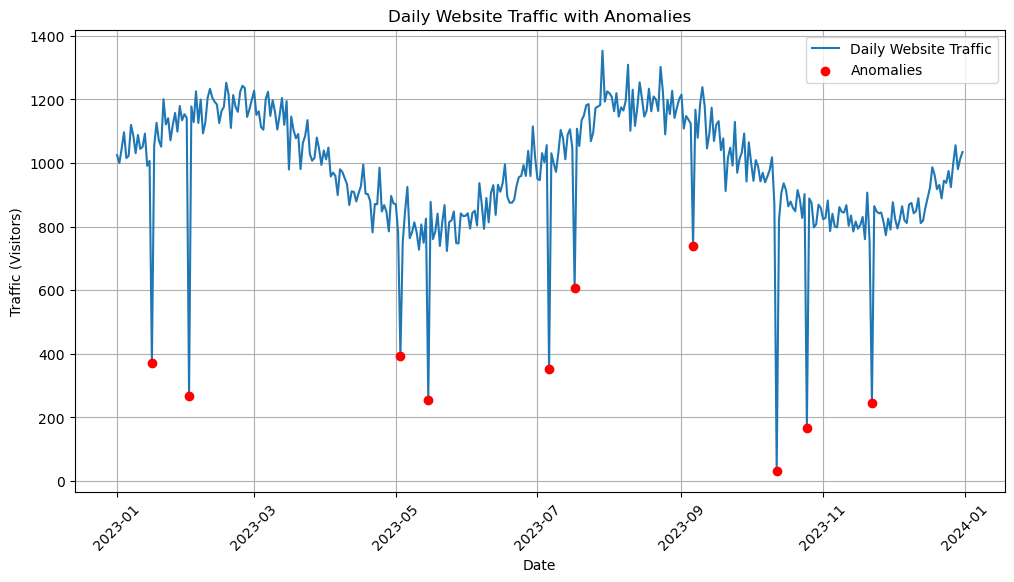

In [23]:
# Plotting the time series with anomalies
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['traffic'], label='Daily Website Traffic')
plt.scatter(df['date'][anomaly_indices], df['traffic'][anomaly_indices], color='red', label='Anomalies', zorder=5)
plt.title('Daily Website Traffic with Anomalies')
plt.xlabel('Date')
plt.ylabel('Traffic (Visitors)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [24]:
# Reshape the data for isolation forest
X = df['traffic'].values.reshape(-1, 1)

# Create true labels based on known anomaly indices
y_true = np.zeros(len(df))
y_true[anomaly_indices] = 1

In [26]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define autoencoder architecture
input_dim = X.shape[1]
encoding_dim = 8
hidden_dim = 4

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
encoder = Dense(hidden_dim, activation='relu')(encoder)

# Decoder
decoder = Dense(encoding_dim, activation='relu')(encoder)
decoder = Dense(input_dim, activation='linear')(decoder)

# Autoencoder model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='mse')

# Train autoencoder
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=32, shuffle=True, verbose=0)

# Get reconstruction error
reconstructed = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)

# Calculate the difference between original and reconstructed values
original_values = df['traffic'].values
reconstructed_unscaled = scaler.inverse_transform(reconstructed).flatten()
differences = original_values - reconstructed_unscaled

# Detect downward anomalies
threshold_down = np.percentile(differences, 3)  # Lower 3 percentile for downward anomalies
y_pred = (differences < threshold_down).astype(int)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [27]:
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [28]:
y_pred.shape

(365,)

In [29]:
y_true

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [30]:
y_true.shape

(365,)

In [31]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[345  10]
 [  9   1]]


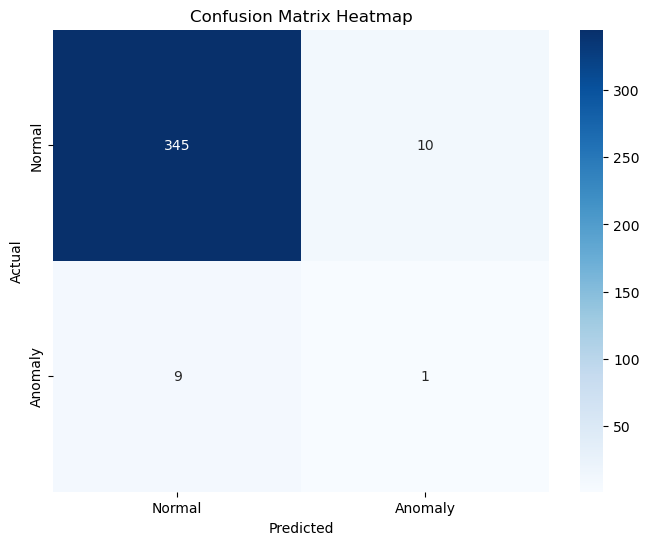

In [32]:
import seaborn as sns

# Visualize the confusion matrix using a heatmap

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'], 
            yticklabels=['Normal', 'Anomaly'])
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [33]:
print("Detailed Confusion Matrix Analysis:")
print("\n1. Basic Metrics:")
print(f"Total samples: {len(y_true)}")
print(f"Total actual anomalies: {sum(y_true)}")
print(f"Total predicted anomalies: {sum(y_pred)}")

print("\n2. Detailed Breakdown:")
tn = conf_matrix[0,0]  # True Negatives
fp = conf_matrix[0,1]  # False Positives
fn = conf_matrix[1,0]  # False Negatives
tp = conf_matrix[1,1]  # True Positives

print(f"True Negatives: {tn} (Normal days correctly identified as normal)")
print(f"False Positives: {fp} (Normal days incorrectly flagged as anomalies)")
print(f"False Negatives: {fn} (Anomalies missed by the model)")
print(f"True Positives: {tp} (Anomalies correctly detected)")

print("\n3. Performance Metrics:")
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Accuracy: {accuracy:.2%}")
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1 Score: {f1:.2%}")

print("\n4. Key Insights:")
print(f"- The model correctly identified {tp}/{tp+fn} actual anomalies")
print(f"- The false alarm rate is {fp/(fp+tn):.2%}")
print(f"- The miss rate is {fn/(fn+tp):.2%}")

Detailed Confusion Matrix Analysis:

1. Basic Metrics:
Total samples: 365
Total actual anomalies: 10.0
Total predicted anomalies: 11

2. Detailed Breakdown:
True Negatives: 345 (Normal days correctly identified as normal)
False Positives: 10 (Normal days incorrectly flagged as anomalies)
False Negatives: 9 (Anomalies missed by the model)
True Positives: 1 (Anomalies correctly detected)

3. Performance Metrics:
Accuracy: 94.79%
Precision: 9.09%
Recall: 10.00%
F1 Score: 9.52%

4. Key Insights:
- The model correctly identified 1/10 actual anomalies
- The false alarm rate is 2.82%
- The miss rate is 90.00%


In [34]:
# Step 4: Additional metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       355
         1.0       0.09      0.10      0.10        10

    accuracy                           0.95       365
   macro avg       0.53      0.54      0.53       365
weighted avg       0.95      0.95      0.95       365



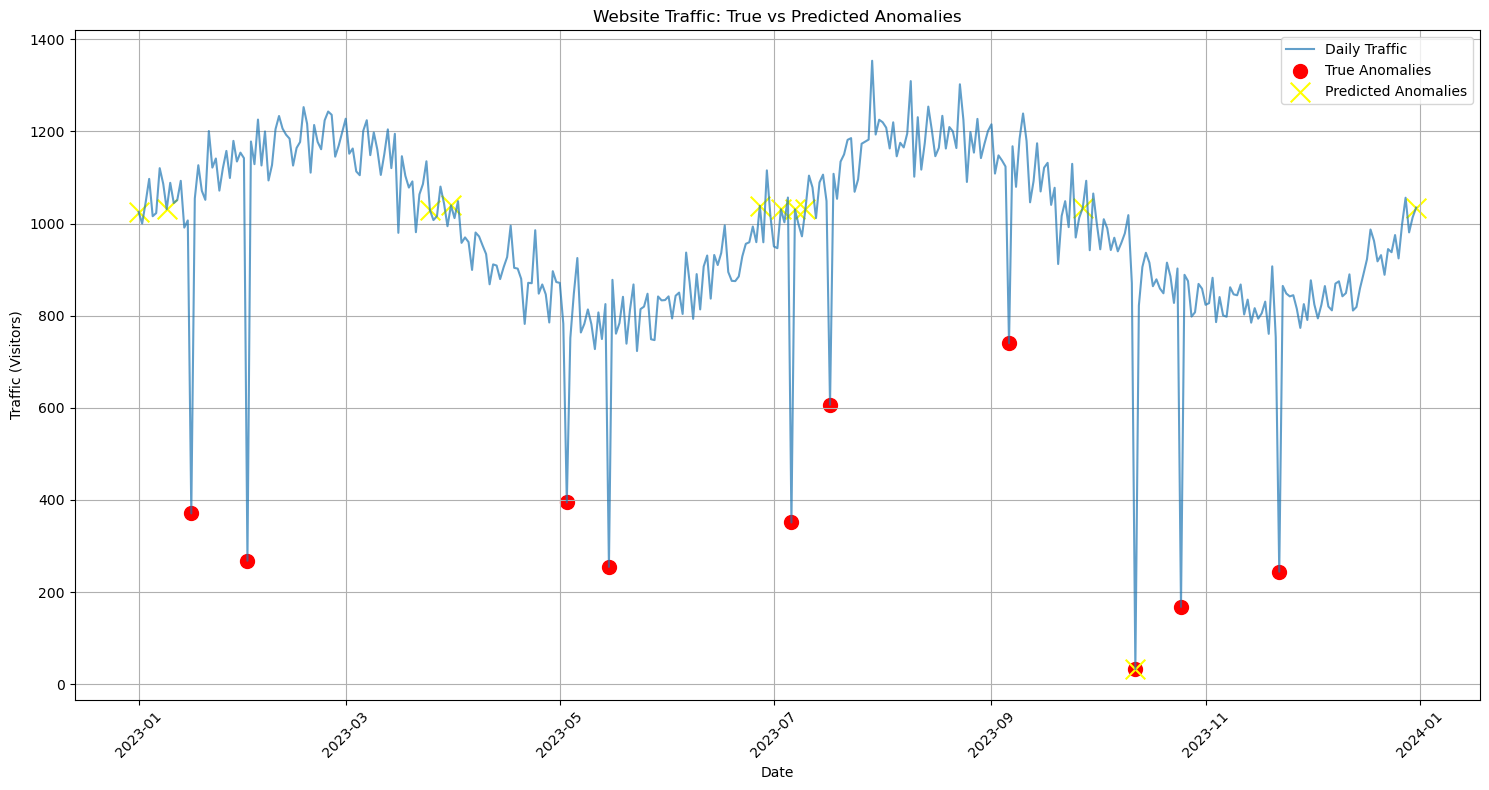

In [35]:
plt.figure(figsize=(15, 8))

# Plot the original traffic data
plt.plot(df['date'], df['traffic'], label='Daily Traffic', alpha=0.7)

# Plot true anomalies
plt.scatter(df['date'][y_true == 1], df['traffic'][y_true == 1], 
           color='red', label='True Anomalies', s=100, marker='o')

# Plot predicted anomalies
plt.scatter(df['date'][y_pred == 1], df['traffic'][y_pred == 1], 
           color='yellow', label='Predicted Anomalies', s=200, marker='x')

plt.title('Website Traffic: True vs Predicted Anomalies')
plt.xlabel('Date')
plt.ylabel('Traffic (Visitors)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()